# Ocean Currents (Stochastic Setting)

This notebook runs experiments for ocean currents in stochastic setting where $\sigma>0$

In [1]:
%load_ext autoreload
%autoreload 2
import os
import time

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import scanpy as sc
import torch
import torchsde
from torchdyn.core import NeuralODE
from tqdm import tqdm
import anndata as ad
import pandas as pd
import scvelo as scv
import torch

from torchcfm import optimal_transport
from torchcfm.conditional_flow_matching import *
from torchcfm.models import MLP
from torchcfm.utils import plot_trajectories, torch_wrapper

2025-11-30 22:07:36.287992: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-30 22:07:36.304368: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764540456.322505 3952231 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764540456.327726 3952231 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1764540456.342320 3952231 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [2]:
# set seed
torch.manual_seed(0)
np.random.seed(0)

In [ ]:
# set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
# load Oceans data
from pathlib import Path
ROOT = Path.cwd().resolve()
while ROOT != ROOT.parent and not ((ROOT / ".git").exists() or (ROOT / "pyproject.toml").exists() or (ROOT / "setup.py").exists()):
    ROOT = ROOT.parent

path = ROOT / "data" / "oceans" / "oceans.npz"
loaded_data = np.load(path)
positions, velocities = loaded_data["positions"], loaded_data["velocities"]
print(positions.shape, velocities.shape)

num_times = positions.shape[0]
num_particles = positions.shape[1]
d = positions.shape[-1]

k = 20 # knn number

(9, 111, 2) (9, 111, 2)


In [5]:
from scipy.interpolate import griddata

def plot_stream_vectorfield(x, v, ax = None, x_min = None, x_max = None, y_min = None, y_max = None, N = 15, linewidth = None, lw0 = 1.0, **kwargs):
    x_min = x[:, 0].min() if x_min is None else x_min
    x_max = x[:, 0].max() if x_max is None else x_max
    y_min = x[:, 0].min() if y_min is None else y_min
    y_max = x[:, 0].max() if y_max is None else y_max
    _x, _y = np.meshgrid(np.linspace(x_min, x_max, N), np.linspace(y_min, y_max, N))
    _u = griddata((x[:, 0], x[:, 1]), v[:, 0], (_x, _y), method='linear', fill_value = 0)
    _v = griddata((x[:, 0], x[:, 1]), v[:, 1], (_x, _y), method='linear', fill_value = 0)
    speed = np.sqrt(_u**2 + _v**2)
    lw = 5*speed / speed.max() * lw0
    if ax is None:
        plt.streamplot(_x, _y, _u, _v, linewidth = lw if linewidth is None else linewidth, **kwargs)
    else:
        ax.streamplot(_x, _y, _u, _v, linewidth = lw if linewidth is None else linewidth, **kwargs)

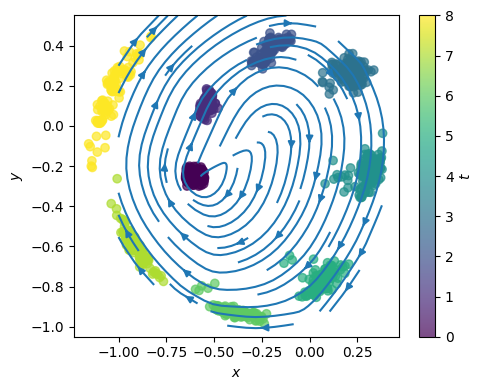

In [6]:
plt.figure(figsize=(5, 4))

plot_stream_vectorfield(
    positions.reshape(-1, d),
    velocities.reshape(-1, d),
    linewidth=1.5,
    x_min=-1.0,
    x_max=0.5,
    y_min=-1.05,
    y_max=0.55,
    lw0=1.5,
    N=15,
)

# Flatten all positions and create corresponding time labels
all_x = []
all_y = []
all_t = []

for t in range(num_times):
    x = positions[t][:, 0]
    y = positions[t][:, 1]
    all_x.append(x)
    all_y.append(y)
    all_t.append(np.full_like(x, t))

all_x = np.concatenate(all_x)
all_y = np.concatenate(all_y)
all_t = np.concatenate(all_t)

# Scatter with color as time
sc = plt.scatter(all_x, all_y, c=all_t, cmap="viridis", alpha=0.7)

plt.xlabel(r"$x$")
plt.ylabel(r"$y$")
cbar = plt.colorbar(sc)
cbar.set_label(r"$t$")
plt.tight_layout()
plt.show()

In [7]:
# create train and test datasets: train ts = [0, 2, 4, 6, 8], test ts = [1, 3, 5, 7]
train_ts = [0, 2, 4, 6, 8]
test_ts = [1, 3, 5, 7]

x_train, v_train = [], []
x_test, v_test = [], []

for t in range(num_times):
    if t in train_ts:
        x_train.append(positions[t])
        v_train.append(velocities[t])
    elif t in test_ts:
        x_test.append(positions[t])
        v_test.append(velocities[t])
        
x_train = np.stack(x_train)
v_train = np.stack(v_train)
x_test = np.stack(x_test)
v_test = np.stack(v_test)

print(x_train.shape, v_train.shape)
print(x_test.shape, v_test.shape)

(5, 111, 2) (5, 111, 2)
(4, 111, 2) (4, 111, 2)


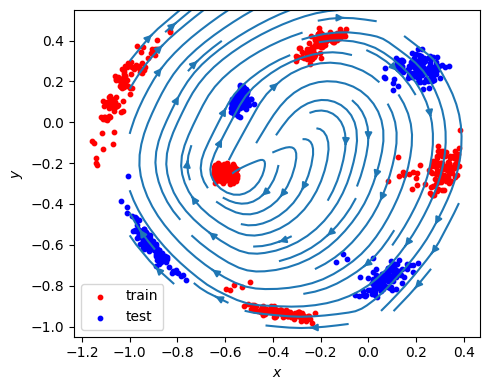

In [8]:
# create plot of train (o's) and test (x's) datapoinst using scatter on plot_stream_vectorfield
plt.figure(figsize=(5, 4))
plot_stream_vectorfield(
    positions.reshape(-1, d),
    velocities.reshape(-1, d),
    linewidth=1.5,
    x_min=-1.0,
    x_max=0.5,
    y_min=-1.05,
    y_max=0.55,
    lw0=1.5,
    N=15,
)
plt.scatter(
    x_train.reshape(-1, d)[:, 0],
    x_train.reshape(-1, d)[:, 1],
    c="red",
    s=10,
    label="train",
)
plt.scatter(
    x_test.reshape(-1, d)[:, 0],
    x_test.reshape(-1, d)[:, 1],
    c="blue",
    s=10,
    label="test",
)
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")
plt.legend(loc="lower left")
plt.tight_layout()
plt.show()

In [9]:
from matplotlib.colors import Normalize
from matplotlib.lines import Line2D

def plot_trajectories_on_data(
    positions, traj, num_trajectories=15, ts_train=None, ts_test=None
):
    """
    Plots time-colored data points with global colormap and overlays learned trajectories.
    Train = circles, Test = X's. Color encodes time globally.

    Args:
        positions: np.ndarray of shape (T, N, 2), ground truth particle positions.
        traj: np.ndarray of shape (T, N', 2), learned trajectories.
        num_trajectories: int, number of trajectories to plot.
        ts_train: list of ints, time steps in training.
        ts_test: list of ints, time steps in testing.
    """
    T, N, _ = positions.shape
    _, N_traj, _ = traj.shape

    # Gather train and test positions
    def collect_points(ts):
        x, y, t = [], [], []
        for ti in ts:
            x.append(positions[ti][:, 0])
            y.append(positions[ti][:, 1])
            t.append(np.full(N, ti))
        return np.concatenate(x), np.concatenate(y), np.concatenate(t)

    train_x, train_y, train_t = (
        collect_points(ts_train)
        if ts_train
        else (np.array([]), np.array([]), np.array([]))
    )
    test_x, test_y, test_t = (
        collect_points(ts_test)
        if ts_test
        else (np.array([]), np.array([]), np.array([]))
    )

    # Compute global time range and shared normalization
    all_t = np.concatenate([train_t, test_t])
    norm = Normalize(vmin=all_t.min(), vmax=all_t.max())

    # Plot train points (circles)
    if train_x.size > 0:
        plt.scatter(
            train_x,
            train_y,
            c=train_t,
            cmap="viridis",
            norm=norm,
            alpha=0.7,
            s=20,
            marker="o",
        )

    # Plot test points (X's)
    if test_x.size > 0:
        sc = plt.scatter(
            test_x,
            test_y,
            c=test_t,
            cmap="viridis",
            norm=norm,
            alpha=0.7,
            s=20,
            marker="d",
        )

    # Overlay learned trajectories
    for i in range(min(num_trajectories, N_traj)):
        plt.plot(traj[:, i, 0], traj[:, i, 1], color="grey", alpha=0.1, linewidth=0.5)

    # Custom legend for markers
    legend_elements = [
        Line2D([0], [0], marker='o', linestyle="None", color='black', label='Train', markersize=4),
        Line2D([0], [0], marker='d', linestyle="None", color='black', label='Test', markersize=4),
    ]
    plt.legend(handles=legend_elements, loc="lower left", markerscale=2)
    
    plt.xlabel(r"Longitude")
    plt.ylabel(r"Latitude")
    cbar = plt.colorbar(sc)
    cbar.set_label(r"$t$")
    plt.tight_layout()
    plt.show()


In [10]:
for t in range(len(train_ts) - 1):
    print(t, t + 1/2, train_ts[t], test_ts[t])

0 0.5 0 1
1 1.5 2 3
2 2.5 4 5
3 3.5 6 7


In [11]:
def get_ut_knn_gaussian(
    xt: torch.Tensor,  # (M, d) query positions
    x0: torch.Tensor,  # (N0, d) snapshot‑0 positions
    x1: torch.Tensor,  # (N1, d) snapshot‑1 positions
    v0: torch.Tensor,  # (N0, d_v) snapshot‑0 velocities
    v1: torch.Tensor,  # (N1, d_v) snapshot‑1 velocities
    k: int = 100,
    eps: float = 1e-12,
):
    # (N, d) full reference set
    x = torch.cat([x0, x1], dim=0)
    v = torch.cat([v0, v1], dim=0)

    # pairwise distances (M, N)
    dists = torch.cdist(xt, x)

    # k nearest for every query
    knn_dists, knn_idx = torch.topk(dists, k=k, dim=1, largest=False)

    # adaptive bandwidth: distance to the furthest of the k neighbours
    h = knn_dists[:, -1:].clamp_min(eps)  # (M, 1)

    # Gaussian kernel weights
    w = torch.exp(-(knn_dists**2) / (2 * h**2))  # (M, k)
    # w = torch.exp(- (knn_dists / h) ** 2)
    w = w / (w.sum(dim=1, keepdim=True) + eps)  # normalise

    # gather neighbour velocities and form weighted sum
    v_knn = v[knn_idx]  # (M, k, d_v)
    v_xt = (w.unsqueeze(-1) * v_knn).sum(dim=1)

    return v_xt


In [12]:
import torch.nn.functional as F

class CurlyWrapperWithMetrics(torch.nn.Module):
    def __init__(self, model, x0, x1, v0, v1, k):
        super().__init__()
        self.model = model
        self.x0 = x0
        self.x1 = x1
        self.v0 = v0
        self.v1 = v1
        self.k = k

    def forward(self, t, z, *args, **kwargs):
        x = z[:, :-2]
        x_dot = self.model(torch.cat([x, t.repeat(x.shape[0])[:, None]], dim=1))

        u_t = get_ut_knn_gaussian(
            x,
            self.x0,
            self.x1,
            self.v0,
            self.v1,
            k=self.k,
        )

        cos_dist = 1 - F.cosine_similarity(u_t, x_dot, dim=1)
        L2_squared = torch.sum((u_t - x_dot) ** 2, dim=1)

        return torch.cat([x_dot, cos_dist.unsqueeze(1), L2_squared.unsqueeze(1)], dim=1)
    

class CurlyWrapperWithMetricsSDE(torch.nn.Module):
    def __init__(self, vel_model, score_model, x0, x1, v0, v1, k):
        super().__init__()
        self.vel_model = vel_model
        self.score_model = score_model
        self.x0 = x0
        self.x1 = x1
        self.v0 = v0
        self.v1 = v1
        self.k = k

    def forward(self, t, z, *args, **kwargs):
        x = z[:, :-2]
        x_dot_vel = self.vel_model(torch.cat([x, t.repeat(x.shape[0])[:, None]], dim=1))
        x_dot_score = self.score_model(torch.cat([x, t.repeat(x.shape[0])[:, None]], dim=1))
        x_dot = x_dot_vel + x_dot_score

        u_t = get_ut_knn_gaussian(
            x,
            self.x0,
            self.x1,
            self.v0,
            self.v1,
            k=self.k,
        )

        cos_dist = 1 - F.cosine_similarity(u_t, x_dot, dim=1)
        L2_squared = torch.sum((u_t - x_dot) ** 2, dim=1)

        return torch.cat([x_dot, cos_dist.unsqueeze(1), L2_squared.unsqueeze(1)], dim=1)


## Curly

In [13]:
from torch.func import vmap
import scipy

def get_xt(t, t_start, x0, x1, geodesic_model, sigma=0.0):
    mu_t = (1 - t) * x0 + t * x1 +  t * (1-t) * (geodesic_model(torch.cat([x0, x1, t+t_start], dim=-1)))
    epsilon = torch.randn_like(x0)
    x_t = mu_t + torch.sqrt(t*(1-t))*sigma * epsilon
    return mu_t, x_t, epsilon

def get_xt_xt_dot(t, t_start, t_end, x0, x1, geodesic_model, sigma=0.0):
    # get xt and xt dot from the geodesic model
    with torch.enable_grad():
        t = t[..., None]
        t.requires_grad_(True)
        #mu_t, xt, eps = NEW_get_xt(t, t_start, t_end, x0, x1, geodesic_model, sigma=sigma)
        mu_t, xt, eps = get_xt(t, t_start, x0, x1, geodesic_model, sigma=sigma)
        mu_t_dot_list = []
        for i in range(xt.shape[-1]):
            mu_t_dot_list.append(
                torch.autograd.grad(torch.sum(mu_t[..., i]), t, create_graph=True)[0]
            )
        # this is velocity (euclidean metric)
        mu_t_dot = torch.cat(mu_t_dot_list, -1)
    return xt, mu_t_dot, eps

def coupling(
    t_start, t_end, x0, x1, x0s, x1s, v0s, v1s, geodesic_model, k, sigma
):
    batch_size, d = x0.shape

    t = torch.rand(1).type_as(x0) * torch.ones((batch_size, batch_size), device=x0.device)
    x0_r = x0.repeat(batch_size, 1, 1)
    x1_r = x1.repeat(batch_size, 1, 1).transpose(0, 1)

    xt, mu_t_dot, eps = get_xt_xt_dot(
        t, t_start, t_end, x0_r, x1_r, geodesic_model, sigma
    )

    ut = vmap(lambda x: get_ut_knn_gaussian(x, x0s, x1s, v0s, v1s, k=k))(xt)

    L2_cost = 0.5 * ((mu_t_dot.detach() - ut) ** 2).sum(-1)
    _, j = scipy.optimize.linear_sum_assignment(L2_cost.detach().cpu().numpy())

    pi_x0 = x0[j]
    pi_x1 = x1

    return pi_x0, pi_x1, eps


In [14]:
def get_batch_geo(geo, X, V, batch_size, sigma, ts_train):
    """Construct a batch with point sfrom each timepoint pair"""
    ts = []
    t_orig_list = []
    mu_t_dots = []
    eps_list = []
    xts = []
    uts = []
    for t_start in range(len(ts_train) - 1):
        t_end = t_start + 1
        
        idcs_0 = np.random.randint(X[t_start].shape[0], size=batch_size)
        idcs_1 = np.random.randint(X[t_end].shape[0], size=batch_size)

        x0 = torch.from_numpy(X[t_start][idcs_0]).float().to(device)
        x1 = torch.from_numpy(X[t_end][idcs_1]).float().to(device)

        v0 = torch.from_numpy(V[t_start][idcs_0]).float().to(device)
        v1 = torch.from_numpy(V[t_end][idcs_1]).float().to(device)
    
        t = torch.rand(x0.shape[0]).type_as(x0) 
        t_o = t
        
        xt, mu_t_dot, eps = get_xt_xt_dot(t, t_start, t_end, x0, x1, geo, sigma=sigma)
        ut = get_ut_knn_gaussian(
            xt,
            x0,
            x1,
            v0,
            v1,
            k=k,
        )
        xt = xt + torch.sqrt(t* (1-t)).unsqueeze(1) * sigma * eps
        
        t_orig_list.append(t_o)
        ts.append(t + t_start)
        xts.append(xt)
        uts.append(ut)
        mu_t_dots.append(mu_t_dot)
        eps_list.append(eps)
    
    t_orig = torch.cat(t_orig_list)
    t = torch.cat(ts)
    xt = torch.cat(xts)
    ut = torch.cat(uts)
    mu_t_dot = torch.cat(mu_t_dots)
    eps = torch.cat(eps_list)

    return t_orig, t, xt, ut, mu_t_dot, eps


In [15]:
batch_size = 64
sigma = 0.1
alpha = 1.0
dim = 2
geo_model = MLP(dim=4, out_dim=dim, time_varying=True, w=64).to(device)
geo_optimizer = torch.optim.AdamW(geo_model.parameters(), 1e-4)

100%|██████████| 5000/5000 [01:05<00:00, 76.56it/s]


Text(0, 0.5, 'Loss')

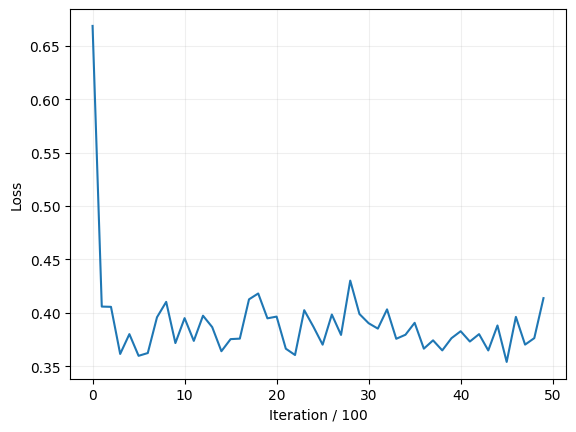

In [16]:
train_loss = []

start_time = time.time()

for i in tqdm(range(5_000)):
    geo_optimizer.zero_grad()
    t_orig, t, xt, ut, mu_t_dot, eps = get_batch_geo(geo_model, x_train, v_train, batch_size, sigma, train_ts)
 
    cosine_loss = 1 - torch.nn.functional.cosine_similarity(ut, mu_t_dot).mean()
    loss = torch.mean((alpha*ut - mu_t_dot) ** 2) + cosine_loss
    
    loss.backward()
    geo_optimizer.step()

    if i % 100 == 0:
        train_loss.append(loss.cpu().item())

end_time = time.time()

train_time_curly_geo = end_time - start_time

plt.plot(train_loss)
plt.grid(alpha=0.2)
plt.xlabel("Iteration / 100")
plt.ylabel("Loss")

In [17]:
def get_batch_vel(geo, X, V, batch_size, sigma, ts_train):
    """Construct a batch with point sfrom each timepoint pair"""
    ts = []
    t_orig_list = []
    mu_t_dots = []
    eps_list = []
    xts = []
    for t_start in range(len(ts_train) - 1):
        t_end = t_start + 1

        idcs_0 = np.random.randint(X[t_start].shape[0], size=batch_size)
        idcs_1 = np.random.randint(X[t_end].shape[0], size=batch_size)

        x0 = torch.from_numpy(X[t_start][idcs_0]).float().to(device)
        x1 = torch.from_numpy(X[t_end][idcs_1]).float().to(device)

        v0 = torch.from_numpy(V[t_start][idcs_0]).float().to(device)
        v1 = torch.from_numpy(V[t_end][idcs_1]).float().to(device)

        t = torch.rand(x0.shape[0]).type_as(x0)
        t_o = t

        x0, x1, _ = coupling(t_start, t_end, x0, x1, x0, x1, v0, v1, geo, k, sigma=sigma)
        xt, mu_t_dot, eps = get_xt_xt_dot(t, t_start, t_end, x0, x1, geo, sigma=sigma)

        t_orig_list.append(t_o)
        ts.append(t + t_start)
        xts.append(xt)
        mu_t_dots.append(mu_t_dot)
        eps_list.append(eps)

    t_orig = torch.cat(t_orig_list)
    t = torch.cat(ts)
    xt = torch.cat(xts)
    mu_t_dot = torch.cat(mu_t_dots)
    eps = torch.cat(eps_list)

    return t_orig, t, xt, mu_t_dot, eps


In [18]:
batch_size = 64
alpha = 1.0
dim = 2

In [19]:
vel_model = MLP(dim=dim, time_varying=True, w=64).to(device).to(device)
score_model = MLP(dim=dim, time_varying=True, w=64).to(device)
sf2m_optimizer = torch.optim.AdamW(
    list(vel_model.parameters()) + list(score_model.parameters()), 1e-4
)

  0%|          | 8/3000 [00:00<01:22, 36.34it/s]

Train loss: 4.0793 | Flow loss: 0.7094 | Score loss: 3.3699


  4%|▎         | 108/3000 [00:02<01:16, 37.82it/s]

Train loss: 1.1244 | Flow loss: 0.1376 | Score loss: 0.9868


  7%|▋         | 208/3000 [00:05<01:15, 36.96it/s]

Train loss: 0.9503 | Flow loss: 0.0359 | Score loss: 0.9144


 10%|█         | 308/3000 [00:08<01:12, 37.23it/s]

Train loss: 0.9386 | Flow loss: 0.0263 | Score loss: 0.9124


 14%|█▎        | 408/3000 [00:10<01:08, 38.06it/s]

Train loss: 0.8950 | Flow loss: 0.0220 | Score loss: 0.8730


 17%|█▋        | 508/3000 [00:13<01:07, 37.14it/s]

Train loss: 1.0208 | Flow loss: 0.0184 | Score loss: 1.0024


 20%|██        | 608/3000 [00:16<01:03, 37.88it/s]

Train loss: 0.8462 | Flow loss: 0.0205 | Score loss: 0.8257


 24%|██▎       | 708/3000 [00:18<01:00, 37.61it/s]

Train loss: 0.9754 | Flow loss: 0.0193 | Score loss: 0.9562


 27%|██▋       | 808/3000 [00:21<01:00, 36.53it/s]

Train loss: 0.8941 | Flow loss: 0.0203 | Score loss: 0.8738


 30%|███       | 904/3000 [00:24<00:59, 35.33it/s]

Train loss: 0.8794 | Flow loss: 0.0227 | Score loss: 0.8567


 34%|███▎      | 1008/3000 [00:27<00:52, 37.79it/s]

Train loss: 0.9296 | Flow loss: 0.0211 | Score loss: 0.9084


 37%|███▋      | 1108/3000 [00:29<00:51, 36.88it/s]

Train loss: 0.8872 | Flow loss: 0.0214 | Score loss: 0.8657


 40%|████      | 1208/3000 [00:32<00:48, 37.05it/s]

Train loss: 0.9721 | Flow loss: 0.0167 | Score loss: 0.9555


 44%|████▎     | 1308/3000 [00:35<00:45, 36.97it/s]

Train loss: 0.7436 | Flow loss: 0.0172 | Score loss: 0.7263


 47%|████▋     | 1408/3000 [00:37<00:42, 37.54it/s]

Train loss: 0.8553 | Flow loss: 0.0187 | Score loss: 0.8366


 50%|█████     | 1508/3000 [00:40<00:39, 37.35it/s]

Train loss: 0.8550 | Flow loss: 0.0162 | Score loss: 0.8389


 54%|█████▎    | 1608/3000 [00:43<00:36, 37.69it/s]

Train loss: 0.7994 | Flow loss: 0.0152 | Score loss: 0.7842


 57%|█████▋    | 1708/3000 [00:45<00:34, 37.69it/s]

Train loss: 0.8617 | Flow loss: 0.0184 | Score loss: 0.8433


 60%|██████    | 1808/3000 [00:48<00:31, 37.91it/s]

Train loss: 0.8124 | Flow loss: 0.0188 | Score loss: 0.7936


 64%|██████▎   | 1908/3000 [00:51<00:29, 37.38it/s]

Train loss: 0.7740 | Flow loss: 0.0134 | Score loss: 0.7606


 67%|██████▋   | 2008/3000 [00:53<00:26, 37.89it/s]

Train loss: 0.8053 | Flow loss: 0.0148 | Score loss: 0.7906


 70%|███████   | 2108/3000 [00:56<00:23, 37.73it/s]

Train loss: 0.8326 | Flow loss: 0.0163 | Score loss: 0.8163


 74%|███████▎  | 2208/3000 [00:59<00:21, 37.60it/s]

Train loss: 0.7798 | Flow loss: 0.0161 | Score loss: 0.7637


 77%|███████▋  | 2308/3000 [01:01<00:18, 37.61it/s]

Train loss: 0.7951 | Flow loss: 0.0149 | Score loss: 0.7802


 80%|████████  | 2408/3000 [01:04<00:16, 35.15it/s]

Train loss: 0.7721 | Flow loss: 0.0129 | Score loss: 0.7592


 84%|████████▎ | 2508/3000 [01:07<00:13, 37.38it/s]

Train loss: 0.8209 | Flow loss: 0.0150 | Score loss: 0.8059


 87%|████████▋ | 2608/3000 [01:09<00:10, 37.59it/s]

Train loss: 0.7082 | Flow loss: 0.0126 | Score loss: 0.6957


 90%|█████████ | 2708/3000 [01:12<00:07, 37.39it/s]

Train loss: 0.6954 | Flow loss: 0.0115 | Score loss: 0.6839


 94%|█████████▎| 2808/3000 [01:15<00:05, 37.77it/s]

Train loss: 0.7309 | Flow loss: 0.0146 | Score loss: 0.7163


 97%|█████████▋| 2904/3000 [01:17<00:02, 34.53it/s]

Train loss: 0.6773 | Flow loss: 0.0119 | Score loss: 0.6654


100%|██████████| 3000/3000 [01:20<00:00, 37.19it/s]


Text(0.5, 0, 'Iteration / 100')

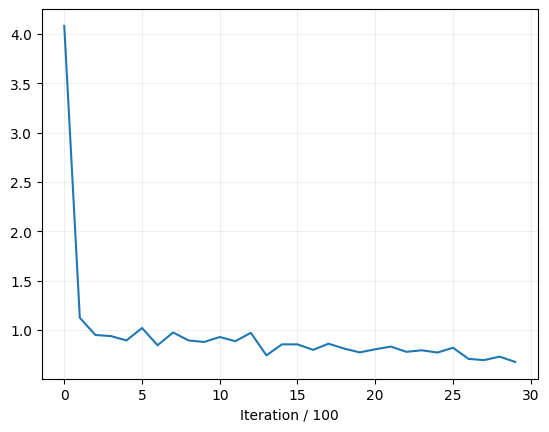

In [20]:
vel_loss = []

start_time = time.time()

for i in tqdm(range(3000)):
    
    sf2m_optimizer.zero_grad()
    
    t_orig, t, xt, mu_t_dot, eps = get_batch_vel(geo_model, x_train, v_train, batch_size, sigma, train_ts)
    vt = vel_model(torch.cat([xt.detach(), t[:, None]], dim=-1))
    st = score_model(torch.cat([xt, t[:, None]], dim=-1))
    
    lambda_t = (2* torch.sqrt(t_orig * (1-t_orig))) / (sigma + 1e-9)
    
    flow_loss = torch.mean((vt - mu_t_dot.detach()) ** 2)
    
    score_loss = torch.mean((lambda_t[:, None] * st + eps) ** 2)
    loss = flow_loss + score_loss

    loss.backward()
    
    sf2m_optimizer.step()

    if i % 100 == 0:
        print(f"Train loss: {loss:.4f} | Flow loss: {flow_loss:.4f} | Score loss: {score_loss:.4f}")
        vel_loss.append(loss.cpu().item())

end_time = time.time()

train_time_curly_vel = end_time - start_time

plt.plot(vel_loss)
plt.grid(alpha=0.2)
plt.xlabel("Iteration / 100")

In [21]:
import torchsde

class MetricSDE(torch.nn.Module):
    noise_type = "diagonal"
    sde_type   = "ito"

    def __init__(self, vel_net, score_net, x0, x1, v0, v1, k, sigma=1.0):
        super().__init__()
        self.vel_net   = vel_net
        self.score_net = score_net
        self.x0, self.x1 = x0, x1
        self.v0, self.v1 = v0, v1
        self.k = k
        self.sigma = sigma                         
        self.input_size = (4,)                   

    def f(self, t, y):
        y = y.view(-1, *self.input_size)
        pos = y[:, : -2]                

        if len(t.shape) == len(pos.shape):
            x = torch.cat([pos, t], 1)
        else:
            x = torch.cat([pos, t.repeat(pos.shape[0])[:, None]], 1)
        xdot = self.vel_net(x).flatten(start_dim=1) + self.score_net(x).flatten(start_dim=1)

        u_t  = get_ut_knn_gaussian(pos,
                                   self.x0, self.x1,
                                   self.v0, self.v1,
                                   k=self.k)    

        cos  = 1 - F.cosine_similarity(u_t, xdot, dim=1)          
        L2   = (u_t - xdot).pow(2).sum(1)                        

        return torch.cat([xdot,
                          cos.unsqueeze(1),
                          L2.unsqueeze(1)], 1)    

    def g(self, t, y):
        noise = self.sigma * torch.ones_like(y)  
        noise[:, -2:] = 0.0  
        return noise

tensor(0.1560)
tensor(0.0902)
tensor(0.1314)
tensor(0.1736)
Avg Cosine distance:  0.060559075
Avg L2 cost:  0.13780367
Avg Wass-1 distance:  0.027282063555610074

----------------------

t            Cosine-dist    &      L2 cost       &       Wass-1 
t2 --- 0.22346745431423187 & 0.1559882014989853 & 0.026402255227613088 \\
t4 --- 0.015727143734693527 & 0.09024178236722946 & 0.04187018492338794 \\
t6 --- 0.0013258494436740875 & 0.13140752911567688 & 0.022390968188316235 \\
t8 --- 0.0017158574191853404 & 0.173577219247818 & 0.018464845883123034 \\

Curly training time -- 2:25 (mins:secs)


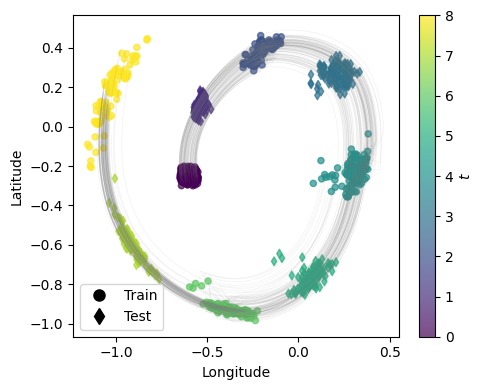

In [22]:
with torch.no_grad():
    trajs = []
    for t in range(len(train_ts) - 1):
        x0 = torch.from_numpy(x_train[t]).float().to(device)
        x1 = torch.from_numpy(x_train[t + 1]).float().to(device)
        v0 = torch.from_numpy(v_train[t]).float().to(device)
        v1 = torch.from_numpy(v_train[t + 1]).float().to(device)

        wrapped_model = CurlyWrapperWithMetrics(vel_model, x0, x1, v0, v1, k)
        node = NeuralODE(wrapped_model, solver="euler", sensitivity="adjoint")

        z0 = torch.cat([x0, torch.zeros(x0.shape[0], 2, device=x0.device)], dim=1)

        out = node.trajectory(
            z0,
            t_span=torch.linspace(t, t + 1, 100),
        ).cpu()

        traj_tmp = out[:, :, :-2]

        trajs.append(traj_tmp)

    traj_curly = torch.cat(trajs, dim=0)

    plt.figure(figsize=(5, 4))

    wass1, cos_dist, L2_cost = [], [], []
    for t, t_train in enumerate(train_ts[:-1]):
        x0 = torch.from_numpy(positions[t_train]).float().to(device)
        x1 = torch.from_numpy(positions[t_train + 1]).float().to(device)
        v0 = torch.from_numpy(velocities[t_train]).float().to(device)
        v1 = torch.from_numpy(velocities[t_train + 1]).float().to(device)

        wrapped_model = CurlyWrapperWithMetrics(vel_model, x0, x1, v0, v1, k)
        node = NeuralODE(wrapped_model, solver="euler", sensitivity="adjoint")

        z0 = torch.cat([x0, torch.zeros(x0.shape[0], 2, device=x0.device)], dim=1)

        pred_out = node.trajectory(
            z0.to(device),
            t_span=torch.linspace(t, t + 1 / 2, 100),
        ).cpu()

        pred_traj = pred_out[:, :, :-2]
        cosine_traj = pred_out[:, :, -2]
        L2_traj = pred_out[:, :, -1]
        pred = pred_traj[-1]

        cos_dist.append(cosine_traj[-1].cpu().mean())
        L2_cost.append(L2_traj[-1].cpu().mean())

        print(L2_traj[-1].cpu().mean())

        wass1.append(optimal_transport.wasserstein(pred, x1.cpu(), power=1))

    cos_dist = np.stack(cos_dist)
    L2_cost = np.stack(L2_cost)

    print("Avg Cosine distance: ", np.mean(cos_dist))
    print("Avg L2 cost: ", np.mean(L2_cost))

    wass1 = np.stack(wass1)
    print("Avg Wass-1 distance: ", np.mean(wass1))

    print()
    print("----------------------")
    print()
    print("t            Cosine-dist    &      L2 cost       &       Wass-1 ")
    for i, t_left_out in enumerate(["t2", "t4", "t6", "t8"]):
        print(t_left_out + f" --- {cos_dist[i]} & {L2_cost[i]} & {wass1[i]} \\\\")

    train_time_curly = train_time_curly_geo + train_time_curly_vel
    minutes = int(train_time_curly // 60)
    seconds = int(train_time_curly % 60)

    print()
    print(f"Curly training time -- {minutes}:{seconds} (mins:secs)")

    plot_trajectories_on_data(
        positions,
        traj_curly.cpu().numpy(),
        num_trajectories=100,
        ts_train=train_ts,
        ts_test=test_ts,
    )

#### SDE version

tensor(0.1746)
tensor(0.0906)
tensor(0.1249)
tensor(0.1877)
Avg Cosine distance:  0.056546204
Avg L2 cost:  0.14443769
Avg Wass-1 distance:  0.05135971424720452

----------------------

t            Cosine-dist    &      L2 cost       &       Wass-1 
t2 --- 0.20821264386177063 & 0.17462733387947083 & 0.059690809324132024 \\
t4 --- 0.01477163564413786 & 0.09058532863855362 & 0.03907967303871168 \\
t6 --- 0.0015163730131462216 & 0.12486402690410614 & 0.04183044880083217 \\
t8 --- 0.0016841606702655554 & 0.18767404556274414 & 0.0648379258251422 \\

Curly training time -- 2:25 (mins:secs)


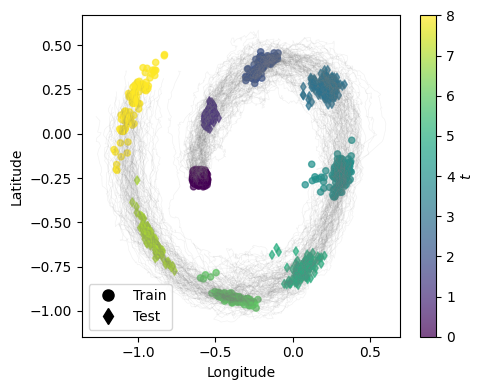

In [23]:
with torch.no_grad():
    trajs = []
    for t in range(len(train_ts) - 1):
        x0 = torch.from_numpy(x_train[t]).float().to(device)
        x1 = torch.from_numpy(x_train[t + 1]).float().to(device)
        v0 = torch.from_numpy(v_train[t]).float().to(device)
        v1 = torch.from_numpy(v_train[t + 1]).float().to(device)


        sde = MetricSDE(vel_model, score_model,
                        x0, x1, v0, v1, k, sigma)
        z0 = torch.cat([x0,
                        torch.zeros(x0.size(0), 2, device=x0.device)], 1)
        
        out = torchsde.sdeint(
                sde,
                z0,
                ts=torch.linspace(t, t + 1, 100, device=x0.device)
            ).cpu()

        # print(out.shape)

        traj_tmp = out[:, :, :-2]

        trajs.append(traj_tmp)

    traj_curly = torch.cat(trajs, dim=0)

    plt.figure(figsize=(5, 4))

    wass1, cos_dist, L2_cost = [], [], []
    for t, t_train in enumerate(train_ts[:-1]):
        x0 = torch.from_numpy(positions[t_train]).float().to(device)
        x1 = torch.from_numpy(positions[t_train + 1]).float().to(device)
        v0 = torch.from_numpy(velocities[t_train]).float().to(device)
        v1 = torch.from_numpy(velocities[t_train + 1]).float().to(device)


        sde = MetricSDE(vel_model, score_model,
                        x0, x1, v0, v1, k, sigma)
        z0 = torch.cat([x0,
                        torch.zeros(x0.size(0), 2, device=x0.device)], 1)

        pred_out = torchsde.sdeint(
                sde,
                z0.to(device),
                ts=torch.linspace(t, t + 1 / 2, 100, device=x0.device),
            ).cpu()

        pred_traj = pred_out[:, :, :-2]
        cosine_traj = pred_out[:, :, -2]
        L2_traj = pred_out[:, :, -1]

        pred = pred_traj[-1]

        cos_dist.append(cosine_traj[-1].cpu().mean())
        L2_cost.append(L2_traj[-1].cpu().mean())

        print(L2_traj[-1].cpu().mean())

        wass1.append(optimal_transport.wasserstein(pred, x1.cpu(), power=1))

    cos_dist = np.stack(cos_dist)
    L2_cost = np.stack(L2_cost)

    print("Avg Cosine distance: ", np.mean(cos_dist))
    print("Avg L2 cost: ", np.mean(L2_cost))

    # plt.title(f"Cosine-dist: {cos_dists_avg:.4f}")

    wass1 = np.stack(wass1)
    print("Avg Wass-1 distance: ", np.mean(wass1))

    print()
    print("----------------------")
    print()
    print("t            Cosine-dist    &      L2 cost       &       Wass-1 ")
    for i, t_left_out in enumerate(["t2", "t4", "t6", "t8"]):
        print(t_left_out + f" --- {cos_dist[i]} & {L2_cost[i]} & {wass1[i]} \\\\")

    train_time_curly = train_time_curly_geo + train_time_curly_vel
    minutes = int(train_time_curly // 60)
    seconds = int(train_time_curly % 60)

    print()
    print(f"Curly training time -- {minutes}:{seconds} (mins:secs)")

    plot_trajectories_on_data(
        positions,
        traj_curly.cpu().numpy(),
        num_trajectories=100,
        ts_train=train_ts,
        ts_test=test_ts,
    )
